In [1]:
### Setting up environment
import numpy as np
from numpy import sqrt
from scipy.linalg import expm, inv, cholesky as chol
import matplotlib.pyplot as plt

### Setting plotting style
plt.style.use('fivethirtyeight')
COLORS = plt.rcParams['axes.prop_cycle'].by_key()['color']

### Seed the RNG
np.random.seed(0)

In [2]:
def pad_to_square(A, n=None):
    nx, ny = A.shape
    if n is None:
        n = max(nx, ny)
    B = np.zeros((n,n))
    B[:nx, :ny] = A
    return B

# 1 Simulation Model $\mathcal{M^S}$

In [3]:
# Simulation parameters
t0, tf = 0, 100
dt = .01

# System parameters
T2, T3 = 5, 1
Q = 2*.1**2*np.eye(3)
F = np.array([[0, 1, 0],
              [0, -1/T2, 1/T2],
              [0, 0, -1/T3]])
L = np.array([[0, 0, 0],
              [0, 0, 0],
              [0, 0, 1/T3]])
G = np.array([[0, 0, 0],
              [0, 0, 0],
              [0, 0, 1]])
P0 = np.diag([1,.1**2, .1**2])

# Measurement parameters
R = 1*np.eye(3)
H = np.array([[1, 0, 0],
              [0, 0, 0],
              [0, 0, 0]])

In [4]:
F2 = np.vstack((np.hstack((F, G@Q@G.T)),
                np.hstack((np.zeros(F.shape), -F.T))))
F2

array([[ 0.  ,  1.  ,  0.  ,  0.  ,  0.  ,  0.  ],
       [ 0.  , -0.2 ,  0.2 ,  0.  ,  0.  ,  0.  ],
       [ 0.  ,  0.  , -1.  ,  0.  ,  0.  ,  0.02],
       [ 0.  ,  0.  ,  0.  , -0.  , -0.  , -0.  ],
       [ 0.  ,  0.  ,  0.  , -1.  ,  0.2 , -0.  ],
       [ 0.  ,  0.  ,  0.  , -0.  , -0.2 ,  1.  ]])

In [5]:
Fi2 = expm(F2*dt)
Fi2

array([[ 1.00000000e+00,  9.99000666e-03,  9.96010313e-06,
         6.66668400e-16, -3.33334489e-13,  6.66336799e-10],
       [ 0.00000000e+00,  9.98001999e-01,  1.98804123e-03,
         3.33334489e-13, -1.33334027e-10,  1.99868399e-07],
       [ 0.00000000e+00,  0.00000000e+00,  9.90049834e-01,
         6.67003468e-10, -2.00135067e-07,  2.00003333e-04],
       [-0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
         1.00000000e+00,  0.00000000e+00, -0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        -1.00100067e-02,  1.00200200e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         1.00401035e-05, -2.01204144e-03,  1.01005017e+00]])

In [6]:
n = 3
Fi12 = Fi2[:n, n:]  # Upper right
Fi22 = Fi2[n:, n:]  # Lower right
Ga = chol(Fi12 @ inv(Fi22), lower=True)

In [7]:
Ga

array([[6.30352113e-08, 0.00000000e+00, 0.00000000e+00],
       [1.57378158e-05, 4.07432794e-06, 0.00000000e+00],
       [1.04656845e-02, 8.14187293e-03, 4.71090429e-03]])

In [8]:
G@G*Q*dt

array([[0.    , 0.    , 0.    ],
       [0.    , 0.    , 0.    ],
       [0.    , 0.    , 0.0002]])

# 2 Discretization

In [9]:
def c2d_determnistic(F, L, dt):
    n = F.shape[0]
    F1 = pad_to_square(np.hstack((F, L)), n=2*n)
    Fi1 = expm(F1*dt)
    Fi = Fi1[:n, :n]  # Upper left
    La = Fi1[:n, n:]  # Upper right
    
    return (Fi, La)

In [10]:
def c2d_stochastic(F, L, G, Q, dt):
    n = F.shape[0]
    F2 = np.vstack((np.hstack((F, pad_to_square(G@Q@G.T, n=n))),
                    np.hstack((np.zeros(F.shape), -F.T))))
    Fi2 = expm(F2*dt)
    Fi12 = Fi2[:n, n:]  # Upper right
    Fi22 = Fi2[n:, n:]  # Lower right
    Ga = chol(Fi12 @ inv(Fi22), lower=True)
    Fi, La = c2d_determnistic(F, L, dt)
    
    return (Fi, La, Ga)

In [11]:
dt = .01

In [12]:
Fi, La = c2d_determnistic(F, L, dt)
Fi, La

(array([[1.00000000e+00, 9.99000666e-03, 9.96010313e-06],
        [0.00000000e+00, 9.98001999e-01, 1.98804123e-03],
        [0.00000000e+00, 0.00000000e+00, 9.90049834e-01]]),
 array([[0.00000000e+00, 0.00000000e+00, 3.32335397e-08],
        [0.00000000e+00, 0.00000000e+00, 9.96010313e-06],
        [0.00000000e+00, 0.00000000e+00, 9.95016625e-03]]))

In [13]:
Fi, La, Ga = c2d_stochastic(F, L, G, Q, dt)
Fi, La, Ga

(array([[1.00000000e+00, 9.99000666e-03, 9.96010313e-06],
        [0.00000000e+00, 9.98001999e-01, 1.98804123e-03],
        [0.00000000e+00, 0.00000000e+00, 9.90049834e-01]]),
 array([[0.00000000e+00, 0.00000000e+00, 3.32335397e-08],
        [0.00000000e+00, 0.00000000e+00, 9.96010313e-06],
        [0.00000000e+00, 0.00000000e+00, 9.95016625e-03]]),
 array([[6.30352113e-08, 0.00000000e+00, 0.00000000e+00],
        [1.57378158e-05, 4.07432794e-06, 0.00000000e+00],
        [1.04656845e-02, 8.14187293e-03, 4.71090429e-03]]))

# 3 Simulation of Stochastic System

In [14]:
t = np.arange(0., tf+dt, dt)
n = t.size
u = np.ones((3,n))

In [15]:
# Deterministic process
Fi, La = c2d_determnistic(F, L, dt)
xd = np.zeros((3, n))

for k in range(n-1):
    xd[:,k+1,np.newaxis] = Fi@xd[:,k,np.newaxis] + La@u[:,k,np.newaxis]

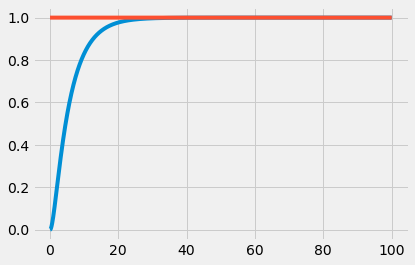

In [16]:
plt.plot(t, xd[1,:])
plt.plot(t, u[1,:])

In [17]:
Fi, La, Ga = c2d_stochastic(F, L, G, Q, dt)
v = np.vstack((np.zeros(n),
               np.zeros(n),
               np.random.randn(n)))
xs = np.zeros((3, n))

for k in range(n-1):
    xs[:,k+1,np.newaxis] = Fi@xd[:,k,np.newaxis] + La@u[:,k,np.newaxis] + Ga@v[:,k,np.newaxis]

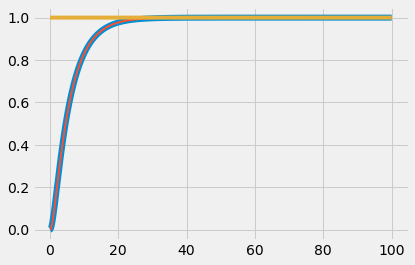

In [18]:
plt.plot(t, xd[1,:], lw=6)
plt.plot(t, xs[1,:], lw=2)
plt.plot(t, u[1,:])

# 4 Optimal Kalman Filter

In [19]:
# Optimal Kalman Filter
Fi, La, Ga = c2d_stochastic(F, L, G, Q, dt)

x = xs[:,:-1:1]  # true state vector
z = H@x + np.vstack((np.random.randn(n-1),  # Measurements
                     np.zeros(n-1),
                     np.zeros(n-1)))

x_bar = np.zeros(xs.shape)  # a-priori state vector estimate
x_hat = np.zeros(x.shape)  # a-posteriori est.
P_bar = np.zeros((n,3,3))  # a-priori covariance matrix estimate
P_hat = np.zeros((n,3,3))  # a-posteriori est.
P_bar[0,...] = P_hat[0,...] = P0

In [20]:
I = np.eye(3)
Qk = Ga@Ga.T

In [21]:
for k in range(n-1):
    # Compute Kalman gain
    K = P_bar[k,...]@H.T@inv(H@P_bar[k,...]@H.T + R)

    # Measurement update
    x_hat[:,k,np.newaxis] = x_bar[:,k,np.newaxis] + K@(z[:,k,np.newaxis] - H@x_bar[:,k,np.newaxis])
    P_hat[k,...] = (I - K@H)@P_bar[k,...]
    
    # Time update
    x_bar[:,k+1,np.newaxis] = Fi@x_hat[:,k,np.newaxis] + La@u[:,k,np.newaxis]
    P_bar[k+1,...] = Fi@P_hat[k,...]@Fi.T + Qk
    


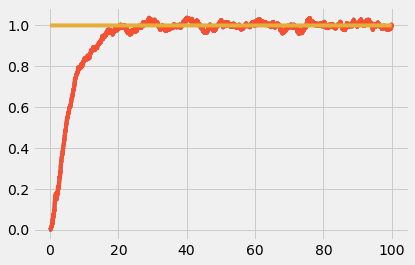

In [26]:
plt.plot(t[:-1],x_hat[1,:])
plt.plot(t[:-1],x_bar[1,:-1])
plt.plot(t[:-1],u[0,:-1])